## Import

In [1]:
%reload_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch
# from functions.trainer import Trainer
from options import update_options, options, reset_options
import argparse
from tensorboardX import SummaryWriter
from easydict import EasyDict as edict

In [4]:
from pathlib import Path
import numpy as np
import matplotlib as plt
import k3d
import trimesh
import torch
import skimage

In [5]:
import json
import os
import pickle

import numpy as np
import torch
from PIL import Image
from skimage import io, transform
from torch.utils.data.dataloader import default_collate

import config
from datasets.base_dataset import BaseDataset
import matplotlib.pyplot as plt
from torchvision.transforms import Normalize

from utils.visualization import visualize_occupancy, visualize_pointcloud, visualize_mesh

/root/miniconda3/envs/3dproject/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [6]:
import torchvision.transforms as transforms

In [7]:
from torch.utils.data import DataLoader

In [8]:
import PIL
from PIL import Image

In [9]:
from datasets.aflwnet import *

## Options

In [7]:
options.train

{'num_epochs': 50,
 'batch_size': 4,
 'summary_steps': 50,
 'checkpoint_steps': 10000,
 'test_epochs': 1,
 'use_augmentation': True,
 'shuffle': True}

In [8]:
options.model

{'name': 'pixel2mesh',
 'hidden_dim': 192,
 'last_hidden_dim': 192,
 'coord_dim': 3,
 'backbone': 'vgg16',
 'gconv_activation': True,
 'z_threshold': 0,
 'align_with_tensorflow': False}

In [9]:
options.model, options.dataset

({'name': 'pixel2mesh',
  'hidden_dim': 192,
  'last_hidden_dim': 192,
  'coord_dim': 3,
  'backbone': 'vgg16',
  'gconv_activation': True,
  'z_threshold': 0,
  'align_with_tensorflow': False},
 {'name': 'shapenet',
  'subset_train': 'train_tf',
  'subset_eval': 'test_tf',
  'camera_f': [248.0, 248.0],
  'camera_c': [111.5, 111.5],
  'mesh_pos': [0.0, 0.0, -0.8],
  'normalization': True,
  'num_classes': 13,
  'shapenet': {'num_points': 3000, 'resize_with_constant_border': False},
  'predict': {'folder': '/tmp'}})

In [10]:
options.dataset

{'name': 'shapenet',
 'subset_train': 'train_tf',
 'subset_eval': 'test_tf',
 'camera_f': [248.0, 248.0],
 'camera_c': [111.5, 111.5],
 'mesh_pos': [0.0, 0.0, -0.8],
 'normalization': True,
 'num_classes': 13,
 'shapenet': {'num_points': 3000, 'resize_with_constant_border': False},
 'predict': {'folder': '/tmp'}}

In [11]:
options.checkpoint_dir, options.checkpoint

# 在CheckpointRunner中的line59: 
# self.saver = CheckpointSaver(self.logger, checkpoint_dir=str(self.options.checkpoint_dir),checkpoint_file=self.options.checkpoint)调用
# 所以在调用时，self.saver = CheckpointSaver(self.logger, checkpoints, None)
# if option.checkpoint = None, 那么self.checkpoint_file = self.get_latest_checkpoint()

# saver初始化时候返回两个属性: self.save_dir, self.checkpoint_file
# 这两个属性，在下面一句self.init_with_checkpoint()中被调用


('checkpoints', None)

In [12]:
options.loss

{'weights': {'normal': 0.00016,
  'edge': 0.3,
  'laplace': 0.5,
  'move': 0.1,
  'constant': 1.0,
  'chamfer': [1.0, 1.0, 1.0],
  'chamfer_opposite': 1.0,
  'reconst': 0.0}}

## 其他

In [10]:
from utils.average_meter import AverageMeter
am1 = AverageMeter()
am1.reset()
am1.update(12)
print(am1)
am1.update(20)
print(am1)
am1.update(1)
print(am1)

12.000000 (12.000000)
20.000000 (16.000000)
1.000000 (11.000000)


## Face_Net

In [7]:
#for face dataset
DATASET_ROOT = "datasets/data"
file_root = os.path.join(DATASET_ROOT, "AFLW2000-3D/AFLW2000")
filename = "image00010.txt"
file_path = os.path.join(file_root, filename)
img_path = file_path[:-4] + ".jpg"

In [8]:
file_path, img_path

('datasets/data/AFLW2000-3D/AFLW2000/image00010.txt',
 'datasets/data/AFLW2000-3D/AFLW2000/image00010.jpg')

In [24]:
#手动读数据
ori_img = io.imread(img_path)
face_3ddata = np.loadtxt(file_path, delimiter=",")
#torch.from_numpy()
pts, normals = face_3ddata[:, :3], face_3ddata[:, 3:]

<class 'numpy.ndarray'> (450, 450, 3)


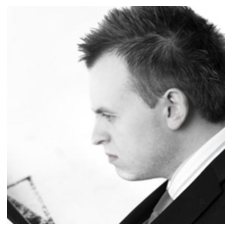

In [25]:
# 2d可视化
print(type(ori_img), ori_img.shape)
plt.imshow(ori_img)
plt.axis('off')
plt.show()

In [15]:
# 3d可视化
visualize_pointcloud(pts, .010)

Output()

In [26]:
# img, pts, normals

img = Image.fromarray(ori_img)
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = data_transform(img)
type(img), img.shape

(torch.Tensor, torch.Size([3, 224, 224]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


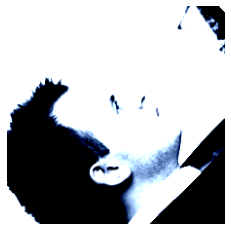

In [28]:
#前处理之后
plt.imshow(img.transpose(0,2))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


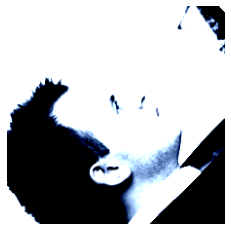

In [29]:
# from jpg to tensor
img = Image.open(img_path)
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = data_transform(img)
plt.imshow(img.transpose(0,2))
plt.axis('off')
plt.show()



### Original Data

In [11]:
DATASET_ROOT = "datasets/data"
file_root = os.path.join(DATASET_ROOT, "shapenet")
filename = "04256520/1a201d0a99d841ca684b7bc3f8a9aa55/rendering/00.dat"

label = filename.split("/", maxsplit=1)[0]#maxsplit=1 ,divide into two parts 04256520
pkl_path = os.path.join(file_root, "data_tf", filename)

In [12]:
img_path = pkl_path[:-4] + ".png"
img_path

'datasets/data/shapenet/data_tf/04256520/1a201d0a99d841ca684b7bc3f8a9aa55/rendering/00.png'

[[ 6.8144500e-01 -3.5104179e-01  6.4218563e-01]
 [-6.3701171e-01 -3.6974090e-01  6.7639321e-01]
 [-6.8144500e-01  3.5104179e-01 -6.4218563e-01]
 ...
 [ 7.9931396e-01 -1.0619049e-01 -5.9145653e-01]
 [-6.4643774e-17 -8.7745941e-01 -4.7965094e-01]
 [-6.5893847e-01 -1.8402964e-02 -7.5197172e-01]]


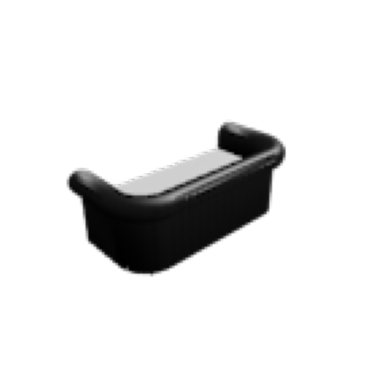

In [13]:
with open(pkl_path) as f:
        data = pickle.load(open(pkl_path, 'rb'), encoding="latin1")#transfer to python files, 'latin1' is the encoder method to the binary file and python object
pts, normals = data[:, :3], data[:, 3:]
# print(data)
# print(pts)
# print("#############")
print(normals)
img = io.imread(img_path)
# else:
#         img = transform.resize(img, (config.IMG_SIZE, config.IMG_SIZE))
#         img = img[:, :, :3].astype(np.float32)
plt.imshow(img)
plt.axis('off')
plt.show()

[[146 146 146  26]
 [150 150 150  24]
 [  0   0   0   3]
 ...
 [ 21  21  21  26]
 [ 29  29  29  93]
 [ 54  54  54  25]]


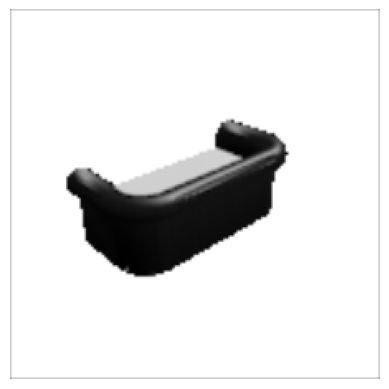

In [14]:
print(img[np.where(img[:, :, 3] != 0)])
img[np.where(img[:, :, 3] == 0)] = 255
img = transform.resize(img, (config.IMG_SIZE, config.IMG_SIZE),
                                       mode='constant', anti_aliasing=False)  # to match behavior of old versions
img = img[:, :, :3].astype(np.float32) #to numpy ndarry!! not a tensor
# else:
#         img = transform.resize(img, (config.IMG_SIZE, config.IMG_SIZE))
#         img = img[:, :, :3].astype(np.float32)
plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
with open(os.path.join(file_root, "meta", "shapenet.json"), "r") as fp:
        labels_map = sorted(list(json.load(fp).keys()))
labels_map = {k: i for i, k in enumerate(labels_map)}

print(labels_map)
labels_map[label]

{'02691156': 0, '02828884': 1, '02933112': 2, '02958343': 3, '03001627': 4, '03211117': 5, '03636649': 6, '03691459': 7, '04090263': 8, '04256520': 9, '04379243': 10, '04401088': 11, '04530566': 12}


9

In [16]:
visualize_pointcloud(pts, .010)

Output()

In [17]:
img = img[:, :, :3].astype(np.float32)
img = torch.from_numpy(np.transpose(img, (2, 0, 1)))
img_normalized =  Normalize(mean=config.IMG_NORM_MEAN, std=config.IMG_NORM_STD)(img)


## Original Shapenet

In [18]:
import config
from datasets.shapenet import *
test_shapenet_options = edict({'num_points': 3000, 'resize_with_constant_border': False})
yu_dataset = ShapeNet(file_root='datasets/data/shapenet',
    file_list_name='yu_train_tf',
    mesh_pos= [0.0, 0.0, -0.8],
    normalization = True,
    shapenet_options = test_shapenet_options)


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/data/shapenet/meta/yu_train_tf.txt'

In [ ]:
# print(f'Length of train set: {len(yu_dataset)}')
# yu_train_sample = yu_dataset[7]
# yu_train_sample

Length of train set: 15


{'images': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6

In [ ]:
# yu_train_sample['points'].shape,yu_train_sample['images'].shape,yu_train_sample['normals'].shape, yu_train_sample['images_orig'].shape

((8698, 3), torch.Size([3, 224, 224]), (8698, 3), torch.Size([3, 224, 224]))

## Dataset & Dataloader

In [31]:
from datasets.aflwnet import *

In [32]:
test_shapenet_options = edict({'num_points': 3000, 'resize_with_constant_border': False})

In [33]:
test_shapenet_options = edict({'num_points': 3000, 'resize_with_constant_border': False})
yu_dataset = AFLW2000(file_root='datasets/data/AFLW2000-3D',
    file_list_name='train_tf_overf',
    mesh_pos= [0.0, 0.0, -0.8],
    normalization = True,
    shapenet_options = test_shapenet_options)

In [34]:
print(f'Length of train set: {len(yu_dataset)}')
yu_train_sample = yu_dataset[7]
yu_train_sample

Length of train set: 16


{'images': tensor([[[-0.1495, -0.1735, -0.1926,  ...,  1.5899,  1.5723,  1.5577],
          [-0.1495, -0.1735, -0.1926,  ...,  1.5899,  1.5740,  1.5875],
          [-0.1495, -0.1735, -0.1926,  ...,  1.5899,  1.5744,  1.5953],
          ...,
          [-1.8953, -1.8953, -1.8953,  ...,  0.5785,  1.4400,  1.7367],
          [-1.8953, -1.8958, -1.8967,  ...,  1.0131,  1.6467,  1.8130],
          [-1.8953, -1.9035, -1.9198,  ...,  1.3174,  1.7218,  1.8040]],
 
         [[-0.0234, -0.0479, -0.0675,  ...,  1.7549,  1.7369,  1.7219],
          [-0.0234, -0.0479, -0.0675,  ...,  1.7549,  1.7386,  1.7524],
          [-0.0234, -0.0479, -0.0675,  ...,  1.7549,  1.7391,  1.7604],
          ...,
          [-1.8081, -1.8081, -1.8081,  ...,  0.7208,  1.6016,  1.9050],
          [-1.8081, -1.8086, -1.8095,  ...,  1.1651,  1.8129,  1.9829],
          [-1.8081, -1.8166, -1.8332,  ...,  1.4763,  1.8897,  1.9737]],
 
         [[ 0.1989,  0.1745,  0.1550,  ...,  1.9693,  1.9514,  1.9365],
          [ 0.1989

In [35]:
yu_train_sample['points'].shape,yu_train_sample['images'].shape,yu_train_sample['normals'].shape, yu_train_sample['images_orig'].shape

((53215, 3), torch.Size([3, 224, 224]), (53215, 3), torch.Size([3, 224, 224]))

In [36]:

visualize_pointcloud(yu_train_sample['points'], .010)

Output()

In [37]:
type(yu_train_sample['images'])
yu_train_sample['images'].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


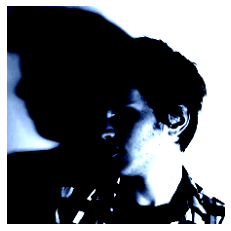

In [38]:
plt.imshow(yu_train_sample['images'].numpy().transpose(1,2,0))
plt.axis('off')
plt.show()

# 这里对tensor的图片显示有点问题

In [29]:
# yu_dataset.file_root
yu_dataset.file_names

['image01854.jpg',
 'image01331.jpg',
 'image03939.jpg',
 'image03738.jpg',
 'image02277.jpg',
 'image00889.jpg',
 'image03551.jpg',
 'image00077.jpg',
 'image02688.jpg',
 'image00907.jpg',
 'image02985.jpg',
 'image00908.jpg',
 'image00080.jpg',
 'image00055.jpg',
 'image02373.jpg',
 'image01317.jpg']

In [39]:
def shapenet_collate(batch):
    if len(batch) > 1:
        all_equal = True
        for t in batch:
            if t["length"] != batch[0]["length"]:
                all_equal = False
                break
        points_orig, normals_orig = [], []
        if not all_equal:
            for t in batch:
                pts, normal = t["points"], t["normals"]
                length = pts.shape[0]
                choices = np.resize(np.random.permutation(length), 3000)
                t["points"], t["normals"] = pts[choices], normal[choices]
                points_orig.append(torch.from_numpy(pts))
                normals_orig.append(torch.from_numpy(normal))
            ret = default_collate(batch)
            ret["points_orig"] = points_orig
            ret["normals_orig"] = normals_orig
            return ret
    ret = default_collate(batch)
    ret["points_orig"] = ret["points"]
    ret["normals_orig"] = ret["normals"]
    return ret

## DataLoader

In [40]:
train_data_loader = DataLoader(yu_dataset,batch_size=2, 
    num_workers=0, 
    pin_memory=False, 
    shuffle=True, 
    collate_fn= shapenet_collate
)

In [41]:
for i, batch in enumerate(train_data_loader):

    for k, v in batch.items():
        print(k + ": ")
        if isinstance(v, torch.Tensor):
            print(v.shape)
        else:
            print(v)
    print('################################')

    if i >=1:
        break


images: 
torch.Size([2, 3, 224, 224])
images_orig: 
torch.Size([2, 3, 224, 224])
points: 
torch.Size([2, 53215, 3])
normals: 
torch.Size([2, 53215, 3])
filename: 
['image02688.jpg', 'image00907.jpg']
length: 
torch.Size([2])
points_orig: 
torch.Size([2, 53215, 3])
normals_orig: 
torch.Size([2, 53215, 3])
################################
images: 
torch.Size([2, 3, 224, 224])
images_orig: 
torch.Size([2, 3, 224, 224])
points: 
torch.Size([2, 53215, 3])
normals: 
torch.Size([2, 53215, 3])
filename: 
['image01317.jpg', 'image02373.jpg']
length: 
torch.Size([2])
points_orig: 
torch.Size([2, 53215, 3])
normals_orig: 
torch.Size([2, 53215, 3])
################################


## Model

In [10]:
# define Model
from models.p2m import P2MModel
from utils.mesh import Ellipsoid
from yu_train_test import summarize_model

yu_ellipsoid = Ellipsoid(mesh_pos=[0.0, 0.0, -0.8])
yu_model = P2MModel(options.model, yu_ellipsoid, camera_f=[248.0, 248.0], camera_c=[111.5, 111.5], mesh_pos=[0.0, 0.0, -0.8])
print(summarize_model(yu_model))


    | Name                  | Type            | Params    
----------------------------------------------------------------
0   | nn_encoder            | VGG16P2M        | 12843632  
1   | nn_encoder.conv0_1    | Conv2d          | 448       
2   | nn_encoder.conv0_2    | Conv2d          | 2320      
3   | nn_encoder.conv1_1    | Conv2d          | 4640      
4   | nn_encoder.conv1_2    | Conv2d          | 9248      
5   | nn_encoder.conv1_3    | Conv2d          | 9248      
6   | nn_encoder.conv2_1    | Conv2d          | 18496     
7   | nn_encoder.conv2_2    | Conv2d          | 36928     
8   | nn_encoder.conv2_3    | Conv2d          | 36928     
9   | nn_encoder.conv3_1    | Conv2d          | 73856     
10  | nn_encoder.conv3_2    | Conv2d          | 147584    
11  | nn_encoder.conv3_3    | Conv2d          | 147584    
12  | nn_encoder.conv4_1    | Conv2d          | 819456    
13  | nn_encoder.conv4_2    | Conv2d          | 590080    
14  | nn_encoder.conv4_3    | Conv2d          | 59

In [62]:
input_tensor = torch.randn(1,3,224,224)
predictions = yu_model(input_tensor)
predictions.keys()

## in p2m.py
# return {
#     "pred_coord": [x1, x2, x3],
#     "pred_coord_before_deform": [init_pts, x1_up, x2_up],
#     "reconst": reconst



dict_keys(['pred_coord', 'pred_coord_before_deform', 'reconst'])

In [65]:
predictions['pred_coord'][-1].shape

torch.Size([1, 2466, 3])

In [70]:
# visualize_pointcloud(predictions['pred_coord'][-1].detach().numpy(), .0010)
# 无意义，只是为了可视化看看

## Train Process

### Overfitting

In [43]:
# yu_model, 
train_data_loader

In [45]:
import yu_train_test
from yu_train_test import yu_train

In [46]:
device = 'cuda'
yu_train(options, yu_model, yu_ellipsoid, device, train_data_loader)
# AverageMeter类型后面的括号里面是当前平均值

RuntimeError: expected scalar type Float but found Double (data<float> at /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/torch/include/ATen/core/TensorMethods.h:1386)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x45 (0x7f5f76133dc5 in /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: float* at::Tensor::data<float>() const + 0xcf (0x7f5f5fc8c0f5 in /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/chamfer-0.0.0-py3.7-linux-x86_64.egg/chamfer.cpython-37m-x86_64-linux-gnu.so)
frame #2: chamfer_cuda_forward(at::Tensor, at::Tensor, at::Tensor, at::Tensor, at::Tensor, at::Tensor) + 0x120 (0x7f5f5fc8af7f in /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/chamfer-0.0.0-py3.7-linux-x86_64.egg/chamfer.cpython-37m-x86_64-linux-gnu.so)
frame #3: chamfer_forward(at::Tensor, at::Tensor, at::Tensor, at::Tensor, at::Tensor, at::Tensor) + 0xc5 (0x7f5f5fc8d515 in /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/chamfer-0.0.0-py3.7-linux-x86_64.egg/chamfer.cpython-37m-x86_64-linux-gnu.so)
frame #4: <unknown function> + 0x11d50 (0x7f5f5fc91d50 in /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/chamfer-0.0.0-py3.7-linux-x86_64.egg/chamfer.cpython-37m-x86_64-linux-gnu.so)
frame #5: <unknown function> + 0x1680a (0x7f5f5fc9680a in /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/chamfer-0.0.0-py3.7-linux-x86_64.egg/chamfer.cpython-37m-x86_64-linux-gnu.so)
frame #6: _PyMethodDef_RawFastCallKeywords + 0x237 (0x4ba8f7 in /root/miniconda3/envs/ml3d/bin/python)
frame #7: /root/miniconda3/envs/ml3d/bin/python() [0x4ba350]
frame #8: _PyEval_EvalFrameDefault + 0x4652 (0x4b6cc2 in /root/miniconda3/envs/ml3d/bin/python)
frame #9: _PyFunction_FastCallDict + 0x116 (0x4cba76 in /root/miniconda3/envs/ml3d/bin/python)
frame #10: THPFunction_apply(_object*, _object*) + 0x691 (0x7f5fa53bf891 in /root/miniconda3/envs/ml3d/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #11: _PyMethodDef_RawFastCallKeywords + 0x1fb (0x4ba8bb in /root/miniconda3/envs/ml3d/bin/python)
frame #12: /root/miniconda3/envs/ml3d/bin/python() [0x4ba350]
frame #13: _PyEval_EvalFrameDefault + 0x4652 (0x4b6cc2 in /root/miniconda3/envs/ml3d/bin/python)
frame #14: _PyFunction_FastCallDict + 0x116 (0x4cba76 in /root/miniconda3/envs/ml3d/bin/python)
frame #15: /root/miniconda3/envs/ml3d/bin/python() [0x4d4230]
frame #16: PyObject_Call + 0x60 (0x4d1be0 in /root/miniconda3/envs/ml3d/bin/python)
frame #17: _PyEval_EvalFrameDefault + 0x1ea5 (0x4b4515 in /root/miniconda3/envs/ml3d/bin/python)
frame #18: _PyEval_EvalCodeWithName + 0x201 (0x4b1411 in /root/miniconda3/envs/ml3d/bin/python)
frame #19: _PyFunction_FastCallDict + 0x2d7 (0x4cbc37 in /root/miniconda3/envs/ml3d/bin/python)
frame #20: _PyObject_Call_Prepend + 0x6e (0x4d152e in /root/miniconda3/envs/ml3d/bin/python)
frame #21: /root/miniconda3/envs/ml3d/bin/python() [0x57d647]
frame #22: _PyObject_FastCallKeywords + 0x430 (0x4c2b60 in /root/miniconda3/envs/ml3d/bin/python)
frame #23: /root/miniconda3/envs/ml3d/bin/python() [0x4ba379]
frame #24: _PyEval_EvalFrameDefault + 0x4652 (0x4b6cc2 in /root/miniconda3/envs/ml3d/bin/python)
frame #25: _PyFunction_FastCallDict + 0x116 (0x4cba76 in /root/miniconda3/envs/ml3d/bin/python)
frame #26: /root/miniconda3/envs/ml3d/bin/python() [0x4d4230]
frame #27: PyObject_Call + 0x60 (0x4d1be0 in /root/miniconda3/envs/ml3d/bin/python)
frame #28: _PyEval_EvalFrameDefault + 0x1ea5 (0x4b4515 in /root/miniconda3/envs/ml3d/bin/python)
frame #29: _PyEval_EvalCodeWithName + 0x201 (0x4b1411 in /root/miniconda3/envs/ml3d/bin/python)
frame #30: _PyFunction_FastCallDict + 0x2d7 (0x4cbc37 in /root/miniconda3/envs/ml3d/bin/python)
frame #31: _PyObject_Call_Prepend + 0x6e (0x4d152e in /root/miniconda3/envs/ml3d/bin/python)
frame #32: /root/miniconda3/envs/ml3d/bin/python() [0x57d647]
frame #33: _PyObject_FastCallKeywords + 0x430 (0x4c2b60 in /root/miniconda3/envs/ml3d/bin/python)
frame #34: /root/miniconda3/envs/ml3d/bin/python() [0x4ba379]
frame #35: _PyEval_EvalFrameDefault + 0x971 (0x4b2fe1 in /root/miniconda3/envs/ml3d/bin/python)
frame #36: _PyEval_EvalCodeWithName + 0x201 (0x4b1411 in /root/miniconda3/envs/ml3d/bin/python)
frame #37: _PyFunction_FastCallKeywords + 0x29c (0x4c50ec in /root/miniconda3/envs/ml3d/bin/python)
frame #38: /root/miniconda3/envs/ml3d/bin/python() [0x4ba23f]
frame #39: _PyEval_EvalFrameDefault + 0x971 (0x4b2fe1 in /root/miniconda3/envs/ml3d/bin/python)
frame #40: _PyEval_EvalCodeWithName + 0x201 (0x4b1411 in /root/miniconda3/envs/ml3d/bin/python)
frame #41: PyEval_EvalCodeEx + 0x39 (0x4b1209 in /root/miniconda3/envs/ml3d/bin/python)
frame #42: PyEval_EvalCode + 0x1b (0x54f39b in /root/miniconda3/envs/ml3d/bin/python)
frame #43: /root/miniconda3/envs/ml3d/bin/python() [0x553c61]
frame #44: _PyMethodDef_RawFastCallKeywords + 0x6c (0x4ba72c in /root/miniconda3/envs/ml3d/bin/python)
frame #45: /root/miniconda3/envs/ml3d/bin/python() [0x4ba350]
frame #46: _PyEval_EvalFrameDefault + 0x971 (0x4b2fe1 in /root/miniconda3/envs/ml3d/bin/python)
frame #47: /root/miniconda3/envs/ml3d/bin/python() [0x4d4b5b]
frame #48: _PyEval_EvalFrameDefault + 0x1ace (0x4b413e in /root/miniconda3/envs/ml3d/bin/python)
frame #49: /root/miniconda3/envs/ml3d/bin/python() [0x4d4b5b]
frame #50: _PyEval_EvalFrameDefault + 0x1ace (0x4b413e in /root/miniconda3/envs/ml3d/bin/python)
frame #51: /root/miniconda3/envs/ml3d/bin/python() [0x4d4b5b]
frame #52: _PyMethodDescr_FastCallKeywords + 0x2dc (0x4c6dbc in /root/miniconda3/envs/ml3d/bin/python)
frame #53: /root/miniconda3/envs/ml3d/bin/python() [0x4ba316]
frame #54: _PyEval_EvalFrameDefault + 0xa9b (0x4b310b in /root/miniconda3/envs/ml3d/bin/python)
frame #55: _PyFunction_FastCallKeywords + 0x106 (0x4c4f56 in /root/miniconda3/envs/ml3d/bin/python)
frame #56: /root/miniconda3/envs/ml3d/bin/python() [0x4ba23f]
frame #57: _PyEval_EvalFrameDefault + 0x971 (0x4b2fe1 in /root/miniconda3/envs/ml3d/bin/python)
frame #58: _PyFunction_FastCallKeywords + 0x106 (0x4c4f56 in /root/miniconda3/envs/ml3d/bin/python)
frame #59: /root/miniconda3/envs/ml3d/bin/python() [0x4ba23f]
frame #60: _PyEval_EvalFrameDefault + 0xa9b (0x4b310b in /root/miniconda3/envs/ml3d/bin/python)
frame #61: _PyEval_EvalCodeWithName + 0x201 (0x4b1411 in /root/miniconda3/envs/ml3d/bin/python)
frame #62: _PyFunction_FastCallDict + 0x2d7 (0x4cbc37 in /root/miniconda3/envs/ml3d/bin/python)
frame #63: /root/miniconda3/envs/ml3d/bin/python() [0x4d4230]


In [38]:
yu_train_sample = yu_dataset[1]
# yu_train_sample['images'].shape
test_image = torch.unsqueeze(yu_train_sample['images'],0)
yu_model.eval()
yu_model.to('cpu')
test_predictions = yu_model(test_image)
visualize_pointcloud(test_predictions['pred_coord'][-1].detach().numpy(), .010)

Output()

In [39]:
test_predictions['pred_coord'][-1].shape

torch.Size([1, 2466, 3])

In [40]:
#对比原始数据
visualize_pointcloud(yu_train_sample['points'], .010)

Output()